In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Соберем данные за полугодовой период, кроме июня
в условии указывалось, что это минимальный вариант, учитывая нехватку производительности, остановлюсь на этом

In [977]:
agg_data_01 = pd.read_csv(r'C:\Users\preductor\Documents\MachineLearning\6_course\Time series analysis\week_3\agg_data_01.csv')
agg_data_02 = pd.read_csv(r'C:\Users\preductor\Documents\MachineLearning\6_course\Time series analysis\week_3\agg_data_02.csv')
agg_data_03 = pd.read_csv(r'C:\Users\preductor\Documents\MachineLearning\6_course\Time series analysis\week_3\agg_data_03.csv')
agg_data_04 = pd.read_csv(r'C:\Users\preductor\Documents\MachineLearning\6_course\Time series analysis\week_3\agg_data_04.csv')
agg_data_05 = pd.read_csv(r'C:\Users\preductor\Documents\MachineLearning\6_course\Time series analysis\week_3\agg_data_05.csv')
agg_data_06 = pd.read_csv(r'C:\Users\preductor\Documents\MachineLearning\6_course\Time series analysis\week_3\agg_data_06.csv')

In [29]:
data_1231_01 = list(agg_data_01.loc[:,'1231'])
data_1231_02 = list(agg_data_02.loc[:,'1231'])
data_1231_03 = list(agg_data_03.loc[:,'1231'])
data_1231_04 = list(agg_data_04.loc[:,'1231'])
data_1231_05 = list(agg_data_05.loc[:,'1231'])
data_1231 = data_1231_01 + data_1231_02 + data_1231_03 + data_1231_04 + data_1231_05

In [1211]:
rng = pd.date_range('6/1/2016 00:00', periods=real_data.shape[0], freq='H')

In [53]:
data = pd.Series(index=range(len(data_1231)), data=data_1231)

In [ ]:
import statsmodels as sm
def TEST(X):
    print('Критерий Дики-Фуллера стационарности ряда {}\n'.format(sm.api.tsa.stattools.adfuller(X)[1]))

    
    pvals = sm.stats.diagnostic.acorr_ljungbox(X)[1]
    print('Q-тест Льюнг — Бокса случайности данных:')
    print('Кол-во pvals, отвергающих случайность: {} из {}\n'.format( sum(pvals<0.05) , len(pvals)))
    
    print('Критерий Стьюдента для несмещенности (равенства 0 среднего) {}'.format(stats.ttest_1samp(X, 0)[1]))
    

## Посмотрим на сырые данные

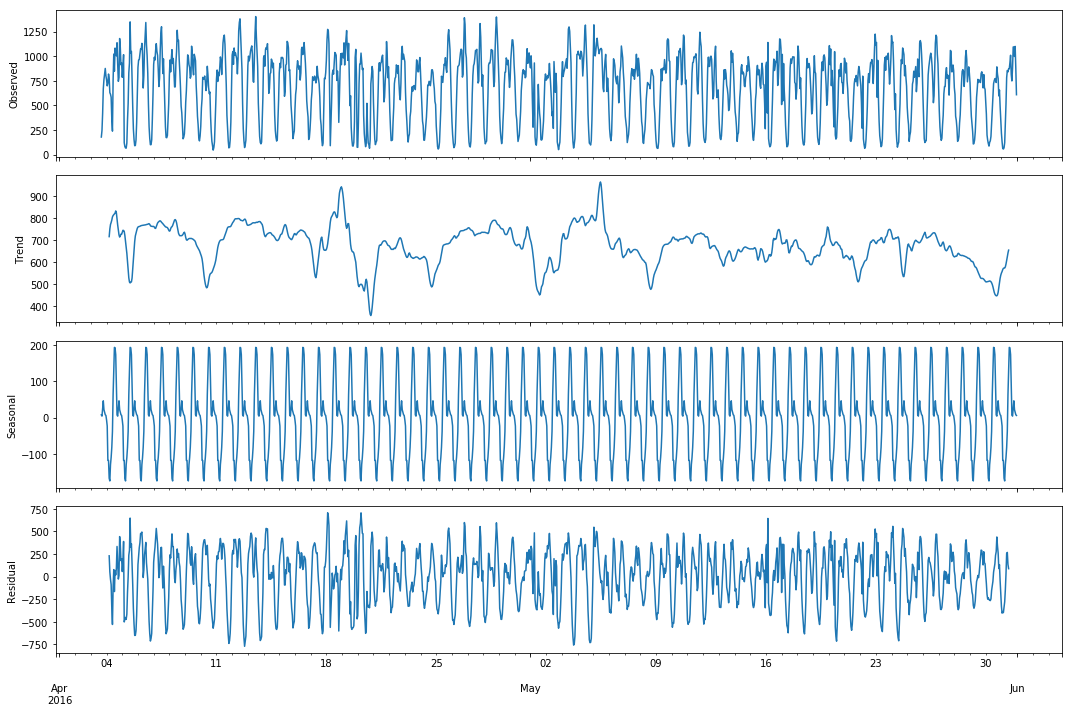

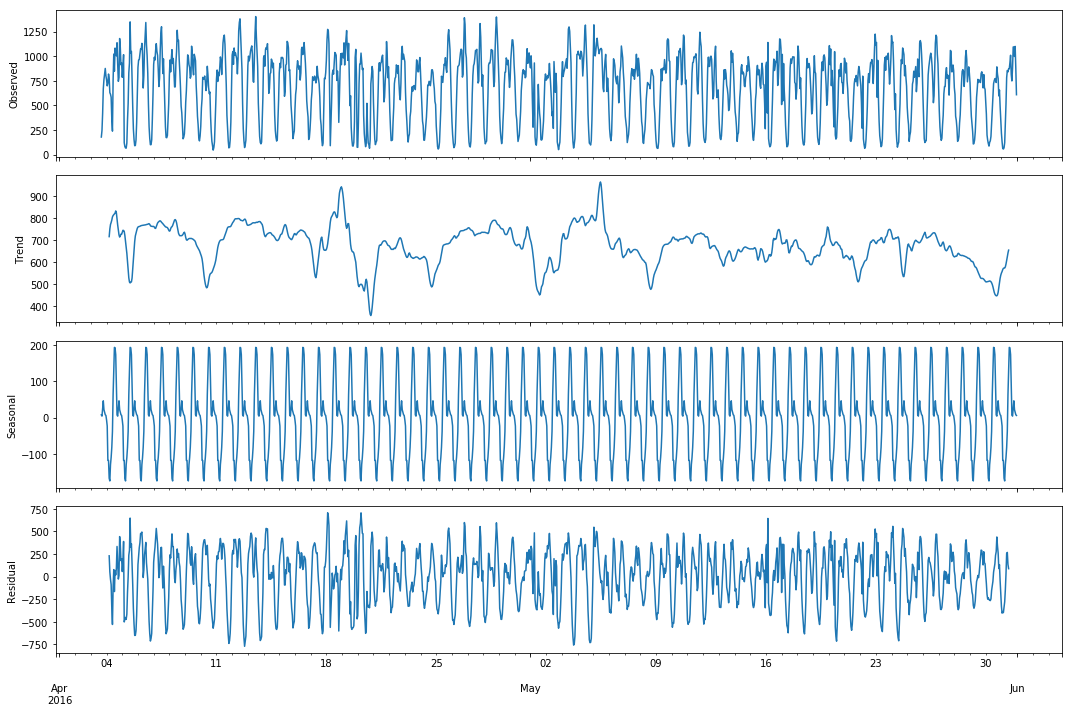

In [914]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
seasonal_decompose(data[-1400:]).plot()

In [915]:
TEST(data)

Критерий Дики-Фуллера стационарности ряда 8.521251319687097e-17

Q-тест Льюнг — Бокса случайности данных:
Кол-во pvals, отвергающих случайность: 40 из 40

Критерий Стьюдента для несмещенности (равенства 0 среднего) 0.0


<font color='green'>Недельная сезонность видна достаточно четко, ряд стационарен даже без регрессии на признаки и дифференцирования если верить критерию Дики-Фуллера</font>

## ------------------------------------------------------------------------------------------

## Посмотрим какие признаки можно включить в регрессию

In [1355]:
X = pd.DataFrame(index=data.index, columns=['holidays'])

In [1344]:
# First one is holidays and weekend indicator
import holidays
X.holidays = [1 if (x in holidays.US() or x.weekday() in [5,6]) else 0 for x in X.index]
# X['weekday'] = [x.weekday() for x in X.index]

In [1356]:
# Second sin and cos harmonics
def harmonics(K):
    for i in range(1,K+1):
        X['s'+str(i)] = np.sin(np.arange(1,len(data)+1)*((2.*np.pi*i)/168))
        X['c'+str(i)] = np.cos(np.arange(1,len(data)+1)*((2.*np.pi*i)/168))
harmonics(30)

In [1346]:
# Third one is weather data from open Kaggle dataset
weather = pd.read_csv('NY_weather-2016.csv')
weather.set_index('date',inplace=True)
weather.index = pd.to_datetime(weather.index)

weather.replace('T',0., inplace=True)
weather.drop(columns=['maximum temperature', 'minimum temperature'], axis=1, inplace=True)

weather = weather.apply(lambda x: x.astype('float16'), axis=1)

In [1347]:
weather.head()

,average temperature,precipitation,snow fall,snow depth
date,,,,
2016-01-01,38.0,0.0,0.0,0.0
2016-02-01,36.0,0.0,0.0,0.0
2016-03-01,40.0,0.0,0.0,0.0
2016-04-01,25.0,0.0,0.0,0.0
2016-05-01,20.0,0.0,0.0,0.0


In [1348]:
X['date'] = X.index.map(lambda x: x.date())
X['date'] = pd.to_datetime(X['date'])
weather['date'] = pd.to_datetime(weather.index)

In [1349]:
X = pd.merge(X, weather, how='inner', on='date').set_index(X.index)

C:\Users\preductor\AppData\Local\conda\conda\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [1357]:
X.drop(columns=['date', 'average temperature'], inplace=True)
X.head()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,...,s26,c26,s27,c27,s28,c28,s29,c29,s30,c30
2016-01-01 00:00:00,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,...,0.826239,0.563320,0.846724,0.532032,8.660254e-01,0.5,0.884115,0.467269,0.900969,0.433884
2016-01-01 01:00:00,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,...,0.930874,-0.365341,0.900969,-0.433884,8.660254e-01,-0.5,0.826239,-0.563320,0.781831,-0.623490
2016-01-01 02:00:00,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,...,0.222521,-0.974928,0.111964,-0.993712,1.224647e-16,-1.0,-0.111964,-0.993712,-0.222521,-0.974928
2016-01-01 03:00:00,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,...,-0.680173,-0.733052,-0.781831,-0.623490,-8.660254e-01,-0.5,-0.930874,-0.365341,-0.974928,-0.222521
2016-01-01 04:00:00,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,...,-0.988831,0.149042,-0.943883,0.330279,-8.660254e-01,0.5,-0.757972,0.652287,-0.623490,0.781831


In [1336]:
# from sklearn.preprocessing import StandardScaler
# X = StandardScaler().fit_transform(X)

## -----------------------------------------------------------------------------------

## Посмотрим на остатки регрессии на составленных признаках

In [800]:
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [1283]:
X.shape

(3648, 63)

In [1358]:
clf = LinearRegression()

In [1352]:
clf.fit(X.iloc[:-168,:].values, data.iloc[:-168])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1249]:
pickle.dump(clf, open('clf.sav', 'wb'))

C:\Users\preductor\AppData\Local\conda\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedWriter name='clf.sav'>
  """Entry point for launching an IPython kernel.


In [1353]:
residuals = data.values-clf.predict(X.values)
res = pd.Series(index=data.index, data=residuals)

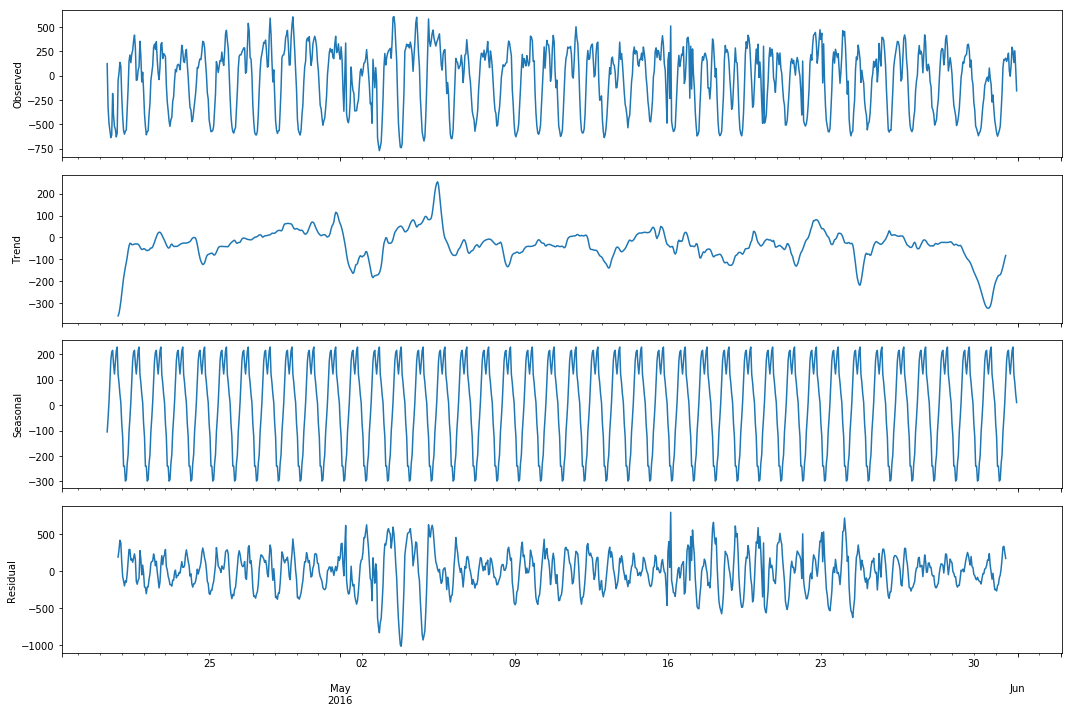

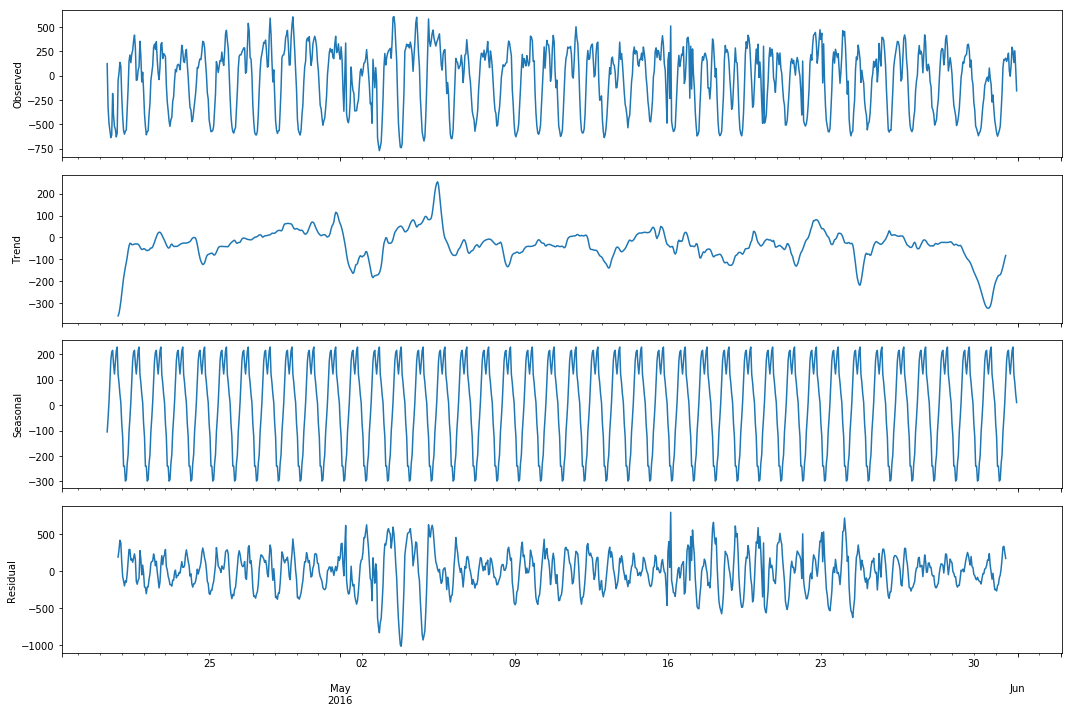

In [1354]:
seasonal_decompose(res[-1000:]).plot()

In [1288]:
TEST(res)

Критерий Дики-Фуллера стационарности ряда 9.607260897088561e-18

Q-тест Льюнг — Бокса случайности данных:
Кол-во pvals, отвергающих случайность: 40 из 40

Критерий Стьюдента для несмещенности (равенства 0 среднего) 0.9999999999999938


<font color='green'>Долго перебирал различные варианты гармоник, праздников и дней недели. В итоге глядя на график остатков пришел к выводу, что индикатор праздников не помогает избежать недельной сезонности, а наоборот. Еще добавил данные о погоде за этот период, хотя не думаю, что они вносят существенный вклад в модель. В задании утверждается, что критерий Дики-Фуллера вряд ли отвергнет теорию о нестационарности ряда, хотя он это делает более чем уверенно</font>

## -----------------------------------------------------------------------------------------

## Применим сезонное дифференцирование
Недельную сезонность вроде бы получилось немного уменьшить, но суточная никуда не делась, проведем сезонное дифференцирование с шагом 24

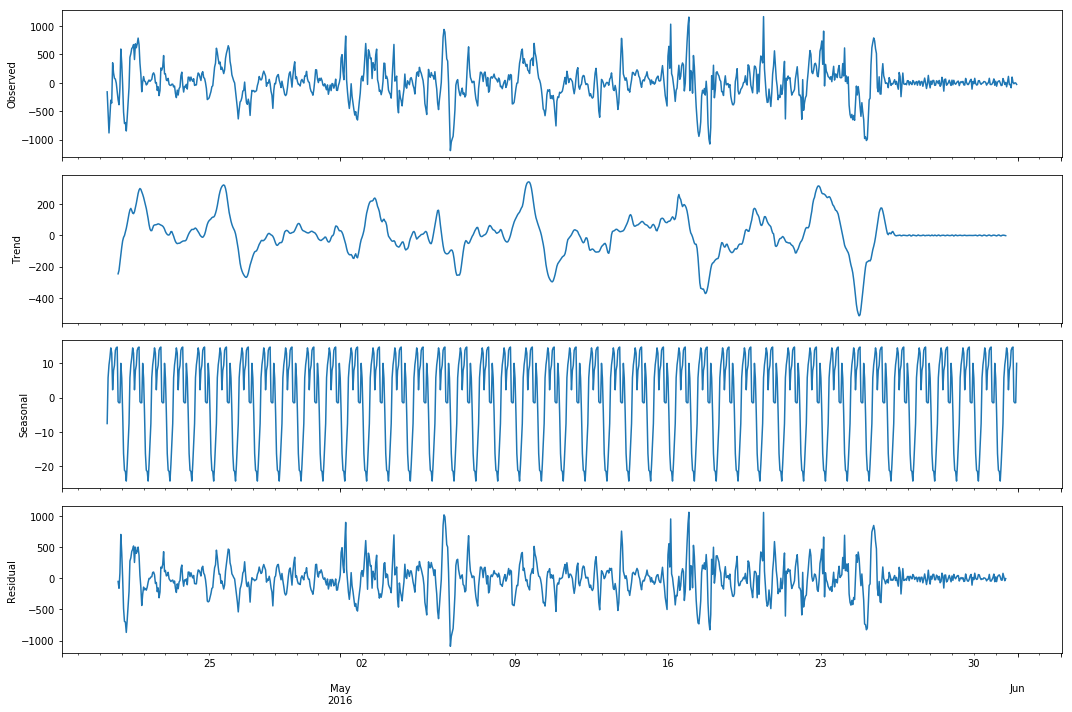

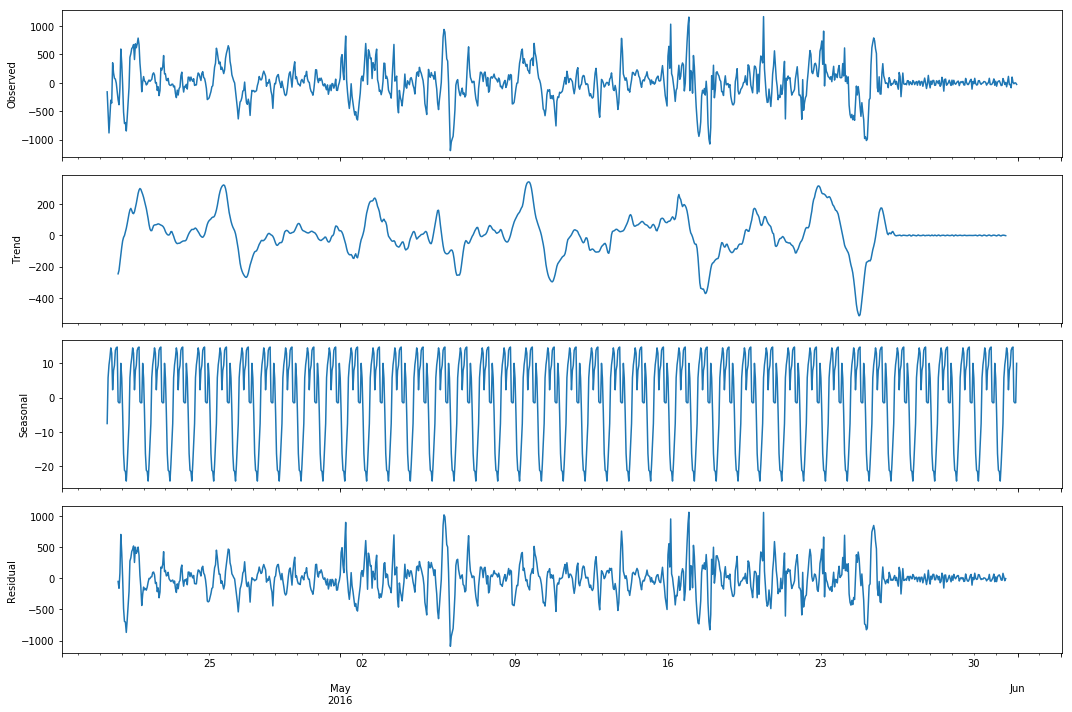

In [1315]:
res_diff24 = (res - res.shift(24))[24:]
seasonal_decompose(res_diff24[-1000:]).plot()

## -------------------------------------------------------------------------------------------

## Начнем подбор параметров ARIMA
Строим acf и pacf полученного ряда

In [1058]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics import tsaplots

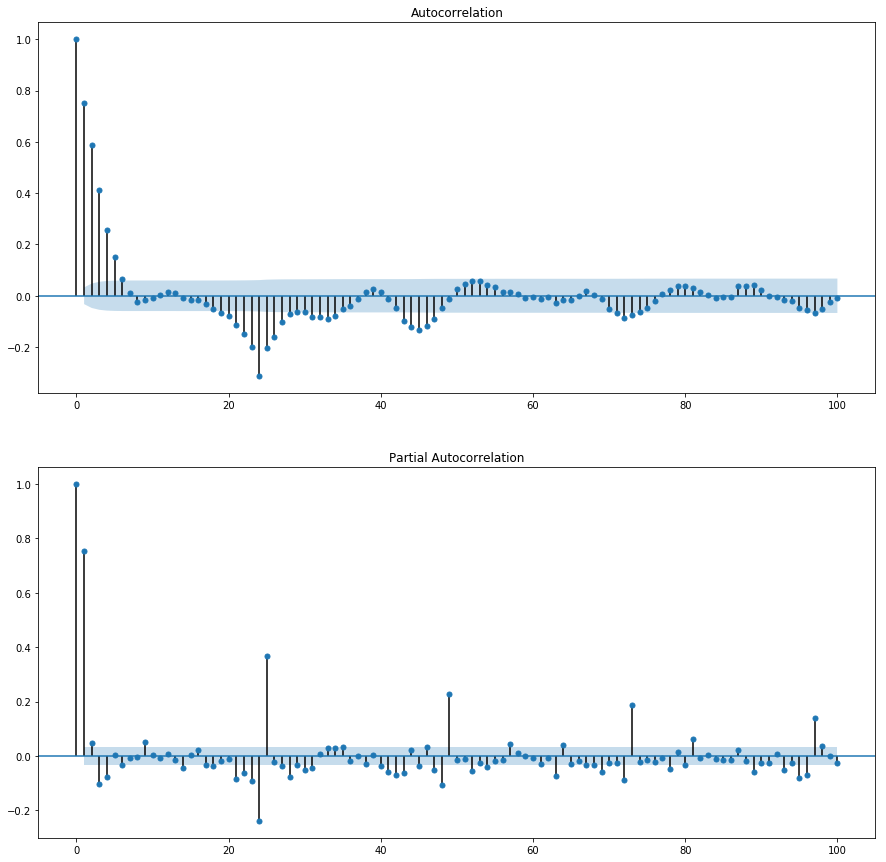

In [1316]:
plt.figure(figsize=(15,15))
ax1 = plt.subplot(211)
tsaplots.plot_acf(res_diff24.values, lags=100, ax=ax1)
ax2 = plt.subplot(212)
tsaplots.plot_pacf(res_diff24.values, lags=100, ax=ax2)
plt.show()

In [1312]:
Qs = range(2)
qs = range(6)
Ps = range(4)
ps = range(5)
D = 1
d = 0

In [1313]:
from itertools import product
parameters = list(product(ps, qs, Ps, Qs))
len(parameters)

240

Начитавшись возмущений с форума поводу времени вычисления не хочу даже пробовать подавать регрессионную компоненту в exog;), поэтому воспользуюсь советом по ссылке и выполню регрессию и SARIMAX отдельно. 
https://www.coursera.org/learn/data-analysis-project/discussions/weeks/3/threads/tgK5YSUHEeebrBIWZEFM5A


In [1289]:
import warnings
results = []
best_aic = float('inf') 
warnings.filterwarnings('ignore')
for idx, param in enumerate(parameters):
    # на некоторых наборах модель не обучается
    try:
        model=SARIMAX(res.iloc[:-168], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и двигаемся дальше
    except ValueError:
        print('wrong parameters: {} number of iteration: {}'.format(param, idx))
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

In [1083]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3648
Model:             SARIMAX(3, 0, 5)x(3, 1, 0, 24)   Log Likelihood              -24565.850
Date:                            Mon, 24 Dec 2018   AIC                          49155.701
Time:                                    17:58:29   BIC                          49230.045
Sample:                                01-01-2016   HQIC                         49182.186
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4349      0.426      3.371      0.001       0.601       2.269
ar.L2         -0.3076      0.724     -0.425      0.671      -1.726       1.111
ar.L3         -0.1499      0.306     -0.489      0.625      -0.751       0.451
ma.L1         -0.7086      0.424     -1.669      0.095      -1.541       0.123
ma.L2         -0.0832      0.416     -0.200      0.842      -0.899       0.733
ma.L3         -0.0410      0.062     -0.659      0.510      -0.163       0.081
ma.L4         -0.0905      0.034     -2.670      0.008      -0.157      -0.024
ma.L5         -0.0554      0.036     -1.551      0.121      -0.126       0.015
ar.S.L24      -0.6271      0.013    -49.208      0.000      -0.652      -0.602
ar.S.L48      -0.3689      0.016    -23.433      0.000      -0.400      -0.338
ar.S.L72      -0.2120      0.014    -15.258      0.000      -0.239      -0.185
sigma2      4.494e+04    756.243     59.420      0.000    4.35e+04    4.64e+04
===================================================================================
Ljung-Box (Q):                      227.60   Jarque-Bera (JB):              1867.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ---------------------------------------------------------------------------------------------

In [1085]:
import pickle
pickle.dump(best_model, open('sarimax.sav', 'wb'))

C:\Users\preductor\AppData\Local\conda\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='sarimax.sav'>
  


In [1013]:
# loaded_model = pickle.load(open('sarimax.sav', 'rb'))
# loaded_model.summary()
# best_model = loaded_model

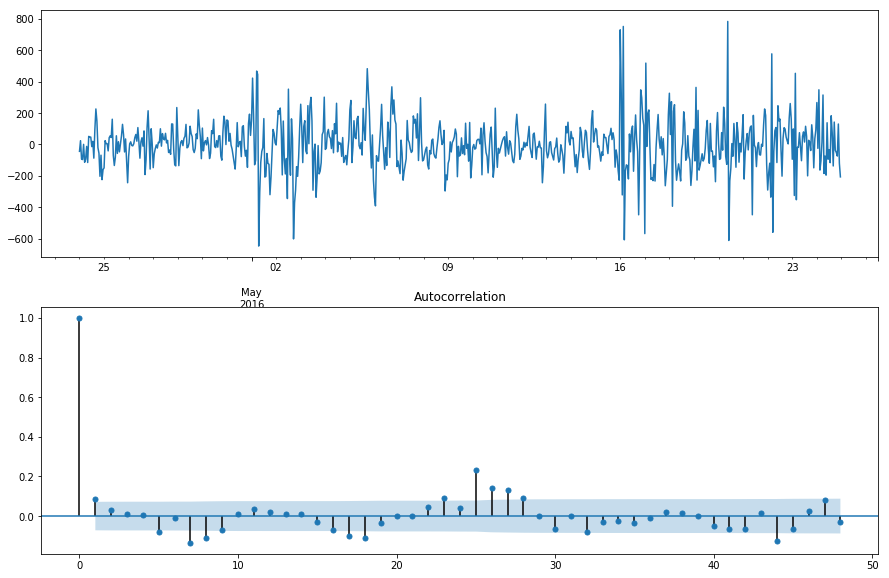

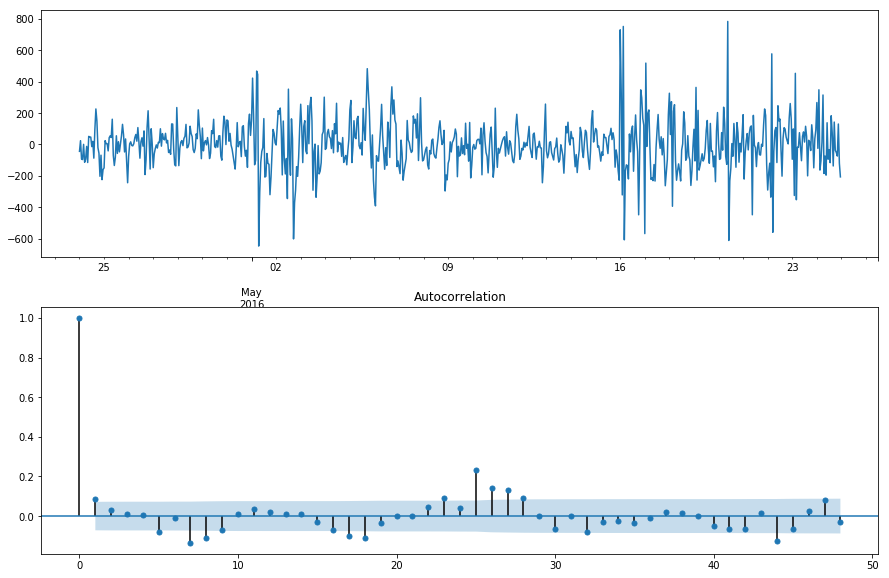

In [1290]:
rcParams['figure.figsize'] = 15,10
ax1 = plt.subplot(211)
best_model.resid[-744:].plot()
ax2 = plt.subplot(212)
tsaplots.plot_acf(best_model.resid[-744:].values, lags=48, ax=ax2)

In [1037]:
TEST(best_model.resid)

Критерий Дики-Фуллера стационарности ряда 1.309023792463706e-21

Q-тест Льюнг — Бокса случайности данных:
Кол-во pvals, отвергающих случайность: 33 из 40

Критерий Стьюдента для несмещенности (равенства 0 среднего) 0.7903402827085495


In [1324]:
X.shape[0]-168

3480

## Посмотрим как ведет себя модель на train и на test данных

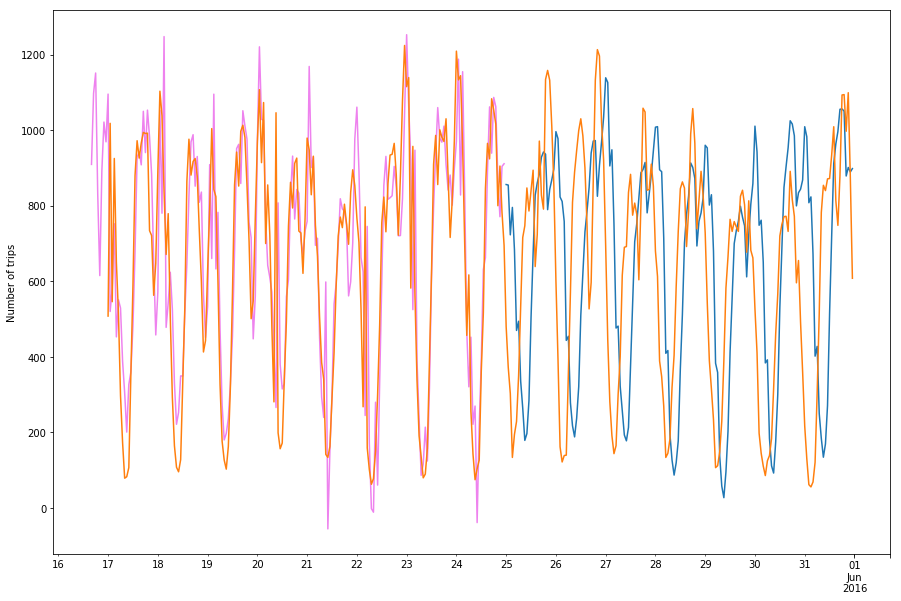

In [1341]:
last_data = best_model.fittedvalues + clf.predict(X.iloc[:-168,:].values)
last_data.iloc[-200:].plot(color='violet') 
future_data = best_model.predict(start=3480, end=3647) + clf.predict(X.iloc[-168:,:].values) 
future_data.plot()
data.iloc[-360:].plot()
plt.ylabel('Number of trips')
plt.show()

<font color='green'>Данные, на которых модель обучалась описаны практически идеально, что не удивительно, но на предсказательной части как будто присутствует лаг в пару часов, природу которого я не очень понимаю</font>

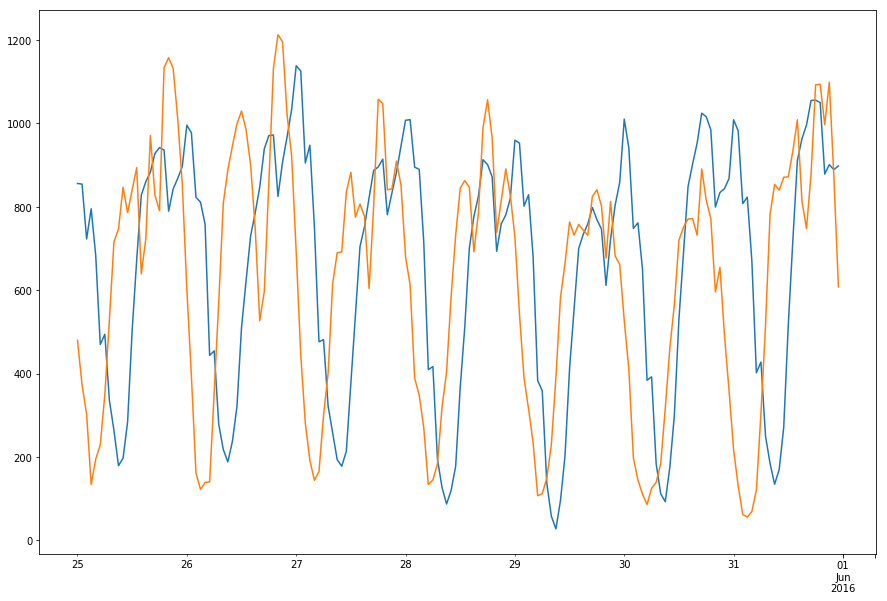

In [1342]:
future_data = best_model.predict(start=3480, end=3647) + clf.predict(X.iloc[-168:,:].values) 
future_data.plot()
data.iloc[-168:].plot()

<font color='red'>Если кто может подсказать почему графики seasonal_decompose, pacf и acf выводятся дублируя себя - напишите, не пойму в чем проблема</font>